## **PART ONE : LENET**

**ALESSIA MARZOTTI 5108443**

**ANUJA SAIRA ABRAHAM 5204982**

link to the source page: https://www.kaggle.com/datasets/hasyimabdillah/workoutexercises-images


link to the dataset file: https://drive.google.com/drive/folders/1f0j_SeJwRigg-sRr0a5vAcBnL7oaePNT?usp=drive_link

size: 866.7 MB


# INTRODUCTION

The dataset used is structured such that each subfolder corresponds to a specific **workout exercise**, each subfolder containing representative images of individual exercises. The objective of this projetc is to conduct a comparative analysis between two models: **LeNet and AlexNet**.



First of all we are going to set up the environment for deep learning using PyTorch and the d2l (dive into deep learning) library in a Google Colab environment.

In [ ]:
 pip install d2l==1.0.0a1.post0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision

In [ ]:
from d2l import torch as d2l
import torch
from torchvision import transforms, datasets
from torch import nn
from torch.utils import data
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
import os
from ctypes import resize
import torchvision.transforms.functional as F



# LeNet architecture

The LeNet model consists of two parts: a convolutional encoder consisting of 2 convolutional layers and a dense fully connected block consisting of 3 fully-connected layers. The visual representation of the model is shown below:



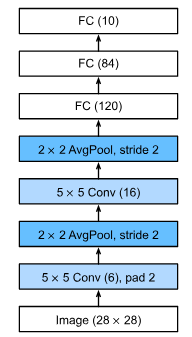

#Implement our model:

In [ ]:

net = torch.nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=11, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(33856, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(84, 22)
    )

We can already see some **differences with the original architecture** :


*   *Bigger kernel size*; in the first convolutional layer we are using a kernel_size equal to 11 instead of 5. The choice of kernel size in a convolutional layer depends on various factors, including the characteristics of the input data and the specific task at hand. Larger kernel sizes are effective in capturing more extensive patterns or features in the input data. Since our input images have larger structures (200*200 pixels), using a larger kernel size can help the model learn and recognize these features more effectively.
*  *ReLU activation function*; after many trials we have noticed that the ReLU activation function was allowing us to get better results. Furthermore the ReLU function is usually prefered to the Sigmoid function for an important reason: *Vanishing Gradient Problem*. Sigmoid functions squish the output between 0 and 1, and for extreme input values, the gradient becomes extremely small. This leads to the vanishing gradient problem, where the gradients during backpropagation become very small, making it challenging for the network to learn. ReLU, being a non-saturating activation function, does not suffer from the vanishing gradient problem as much.
*   *Dropout layer*; we also added a dropout layer with probability 0.6. We noticed that adding a dropout layer with this precise probability was helping us in preventing overfitting and improving the generalization performance of the model.

















The following code is a way to **inspect the output shape** of the input tensor as it passes through each layer of the neural network. This can be useful for understanding how the dimensions of the data evolve through the network architecture:

In [ ]:
X = torch.rand(size=(1, 1, 200, 200), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 194, 194])
ReLU output shape: 	 torch.Size([1, 6, 194, 194])
AvgPool2d output shape: 	 torch.Size([1, 6, 97, 97])
Conv2d output shape: 	 torch.Size([1, 16, 93, 93])
ReLU output shape: 	 torch.Size([1, 16, 93, 93])
AvgPool2d output shape: 	 torch.Size([1, 16, 46, 46])
Flatten output shape: 	 torch.Size([1, 33856])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Dropout output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 22])


In particular, the reason for this high number 33856 after the **flatten output shape**: 33856= 16x46x46.  The AvgPool2d operation with a kernel size of 2x2 reduces the spatial dimensions by half, resulting in an output size of 46x46 for each of the 16 channels. The Flatten operation reshapes the 3D tensor (16 channels, 46x46) into a 1D tensor by concatenating the values along a single dimension. In this case,  16x46x46= 33856. The formula for the flatten output size is (number of channels) * (height) * (width).

Now, since our data is stored in Google Drive we are going to use google.colab library for *file access*:

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Structure of our dataset
Below, the **structure of the dataset** is shown, specifically from which folders it is composed and how many images are in each folder.
Since in the *original dataset*, there were some classes with a significantly higher number of images compared to the average, which was modified from the original dataset by removing the excess images from these folders.

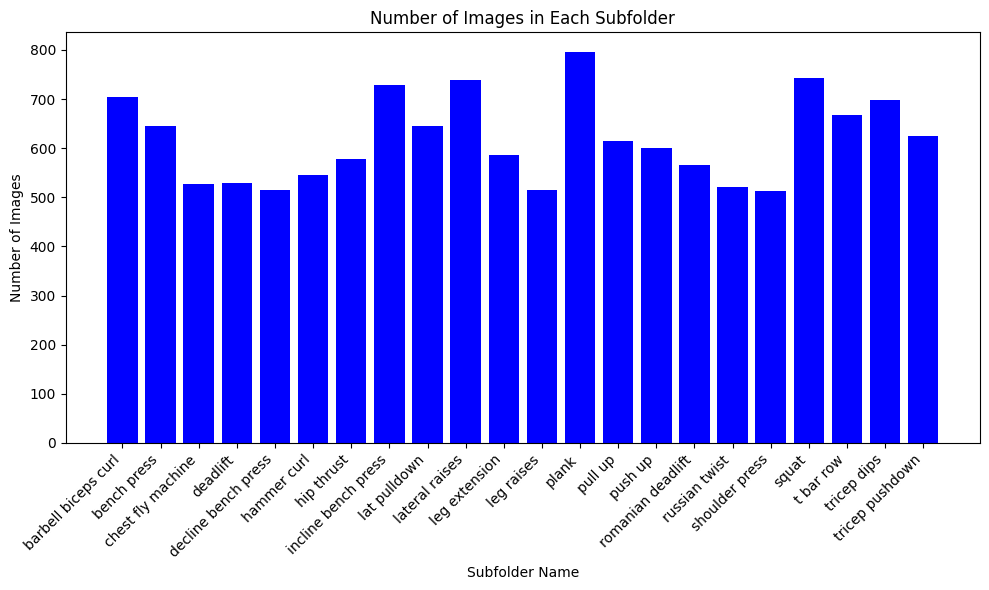

In [ ]:
# Define the root folder containing subfolders with images
root_folder = '/content/drive/MyDrive/workoutexercises/'

# Function to count images in each subfolder
def count_images(folder_path):
    image_counts = []
    folder_names = []

    for folder_name in os.listdir(folder_path):
        folder_path_full = os.path.join(folder_path, folder_name)
        if os.path.isdir(folder_path_full):
            images = [file for file in os.listdir(folder_path_full) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
            image_count = len(images)
            image_counts.append(image_count)
            folder_names.append(folder_name)

    return folder_names, image_counts

# Get folder names and image counts
folders, counts = count_images(root_folder)

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(folders, counts, color='blue')
plt.xlabel('Subfolder Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Subfolder')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Each folder corresponds to a particular workout, and within each folder, there are images related to that specific exercise. It  can  be said that the images are now more or less *uniformly distributed* in the folders.

# Objective
The *goal* is to build a neural network that can **recognize which exercise the person in the photo is performing**. Obviously, this is not a simple task, since many exercises are very similar to each other with small variations in body inclination or rotation. The differences between different exercises are often minimal, making the task of recognizing workout exercises quite challenging.

# Preparing the dataset

This part of the code below prepares the dataset, applying a **data augmentation transformation** to improve data variability and using a DataLoader which is a pytorch function used to upload data from a dataset and provides an iterator that produces minibatches of data during training.


In [ ]:
data_augmentation = transforms.Compose([
        transforms.Resize((200, 200)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])

dataset = datasets.ImageFolder(root='/content/drive/MyDrive/workoutexercises/',
                                         transform= data_augmentation)

some_example_set = data.DataLoader(dataset,
                                             batch_size=25, shuffle=True,
                                             num_workers=2)

In particular input images are **resized** from 480x360 pixels to a fixed size 200x200 pixels and **randomly flipping some of the images horizontally** with a 50% probability. This helps in augmenting the dataset by creating variations of the original images. We are also converting the images to **grayscale**, reducing the number of channels from 3(RGB) to 1(grayscale). Then we convert the images to **PyTorch tensors** and create a dataset using the **'ImageFolder'** function, which assumes that the images are organized in folder where each folder represents a class.

The specified *'transform' is applied to each image udring loading*.
Finally we create a **data loader** that allows to iterate through the dataset in batches, shuffling the data and using multiple workers for faster loading.

*We prefered using Resize() instead of RandomResizedCrop()* because with Resize() we are maintaining the entire content of the image and scaling it to fit within the specified dimensions, which results in stretching or compressing the image. We wanted to be sure that the entire content of the image is visible and there is no distortion due to random cropping and so we prefered Resize() over RandomResizedCrop().

*Below you can also see an example of our images in the GreyScale* :

In [ ]:
data_iter = iter(some_example_set)

In [ ]:
X, y = next(data_iter)
print(dataset[0][0].shape)

torch.Size([1, 200, 200])


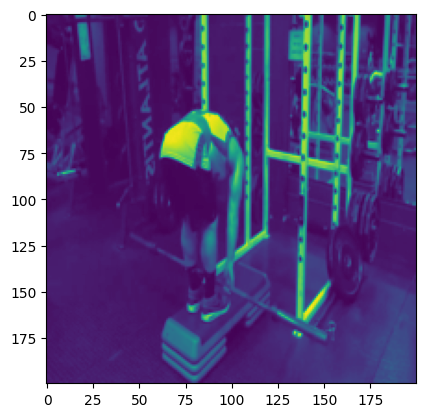

In [ ]:
_ = plt.imshow(np.asarray(X[0][0]))

# TRAIN, TEST AND VALIDATION SET

The following code snippet is involved in splitting a dataset into training, testing, and validation sets using PyTorch's random_split function. It then creates data loaders for each of these sets, facilitating the loading of batches during training, testing, and validation phases.

In [ ]:

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = int(0.1 * dataset_size)
validation_size =  dataset_size-(train_size+test_size)

train_dataset,test_dataset,validation_dataset = random_split(dataset, [train_size, test_size,validation_size])
train_iter = data.DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=2)
test_iter = data.DataLoader(test_dataset, batch_size=25, shuffle=False, num_workers=2)
validation_iter = data.DataLoader(validation_dataset, batch_size=25, shuffle=False, num_workers=2)


**Splitting the dataset into three parts**—training, testing, and validation—is a common practice to evaluate and improve the performance of a model. Each subset serves a specific purpose:

*Training Set*:

The training set is used to train the model's parameters. The model learns patterns and features from the input data, adjusting its weights during the training process to minimize the loss function.

*Testing Set*:

The testing set is used to evaluate the model's performance and assess its generalization to new, unseen data. The model has never seen the testing data during training, so its performance on this set provides an estimate of how well it can generalize to real-world, unseen examples.

*Validation Set*:

The validation set is used during the training phase to fine-tune the model's hyperparameters. It acts as a separate dataset that the model does not use for training, allowing you to assess how well the model is likely to generalize to new data. The performance on the validation set helps in making decisions about adjusting hyperparameters, preventing overfitting, and ensuring the model's robustness.
The reason for having both a testing set and a validation set is to separate the concerns of model development. **The testing set serves as a final evaluation to understand how well the model performs on completely new data. The validation set, on the other hand, helps guide the fine-tuning of the model's parameters during training without introducing the risk of overfitting to the testing data.**

The common split ratios are 80-10-10, where 80% of the data is used for training, 10% for testing, and the remaining portion for validation.

# DEFINING THE TRAINING FUNCTION

The following code **defines a training function** (train) for a neural network. The function takes as input the neural network (net), training and testing data iterators (train_iter and test_iter), the number of training epochs (num_epochs), and the learning rate (lr).

Stochastic Gradient Descent (SGD) is used as the optimizer with the specified learning rate (lr) and the Cross-entropy loss is employed as the loss function.

The goal during training is to minimize the cross-entropy loss, effectively encouraging the model to assign higher probabilities to the correct classes.

The Xavier parameter initialization is designed to help with the convergence of neural network training. This function initializes the weights of a tensor with values drawn from a uniform distribution and is particularly useful to mitigate the vanishing or exploding gradient problem during training.


In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU if available"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization
    net.apply(init_weights)
    print('Training on the device:', device)

    net.to(device) # MOVE the net to the GPU
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss() #CrossValidation Error
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'val acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# RESULTS OBTAINED

The train function is called with the specified parameters (net, train_iter, validation_iter, num_epochs, lr) to **train the neural network on the training set and evaluate it on the validation set**.




*Monitoring the performance on the validation set* we have noticed that it was better to reduce the number of epochs to 9 in order to prevent overfitting. **Early stopping** also helps prevent unnecessary training, saving computation time and resources.

loss 0.642, train acc 0.823, val acc 0.851
1071.7 examples/sec on cuda:0


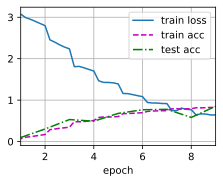

In [ ]:
lr, num_epochs = 0.1, 9
train(net, train_iter, validation_iter, num_epochs, lr)

Results obtained:


*   **Loss (Training Loss)**: The training loss (cross-entropy loss) is 0.642. This is a measure of how well the neural network is performing on the training set. A lower loss indicates better agreement between the predicted and actual labels.
*   **Training Accuracy (train acc)**: The training accuracy is 82.3%. This represents the proportion of correctly classified examples in the training set. An accuracy of 82.3% indicates that the model is correctly predicting the labels for the majority of training examples.
*   **Validation Accuracy (val acc)**: The validation accuracy is 85.1%. This represents the accuracy of the model on the validation set, which consists of data that the model has not seen during training. A validation accuracy of 85.1% is a positive sign, indicating that the model is generalizing well to unseen data.

The reported training **speed** is 1071.7 examples per second. This metric indicates the efficiency of the training process, showing how many examples the model processes in one second.

The training is performed on the 'cuda:0' device, which is indicative of a **GPU** (CUDA) being used for acceleration. Training on a GPU significantly speeds up the computations compared to using just the CPU.

In summary, the results suggest that the model is *learning reasonably well* on the training set (as indicated by the training loss and accuracy). Furthermore, the model *generalizes effectively* to the validation set, and the training process is efficient, running at a speed of 1071.7 examples per second on the specified GPU.






# ASSESS THE PERFORMANCE

We are going to *assess the performance* of a trained neural network on a test set and **visually inspect** a sample of the predictions.

In [ ]:
class_names = ["barbell biceps curl","bench press","chest fly machine","deadlift","decline bench press","hammer curl","hip thrust","incline bench press","lat pulldown",
               "lateral raises","leg extension","leg raises","plank","pull up","push up","romanian deadlift","russian twist","shoulder press","squat","t bar row","tricep dips","tricep pushdown"]

The following code consists of *two functions*:

**evaluate_and_display_images Function**:

*   *Purpose*: evaluate the neural network on a specified data iterator (likely representing the test set) and display a subset of images with their true and predicted labels.

*  *Parameters*: net(the trained neural network to be evaluated), data_iter(the data iterator (test set) from which to obtain images and true labels), class_names(a list or array containing the class names (labels) for interpretation), device(the device on which to perform the evaluation),
num_display(the number of images to display in the visualization).
*  Set the network to evaluation mode and move it to the specified device.Iterates through batches in the data_iter, obtains predictions from the model, and stores true values, predicted values, and images in lists.Calls the display_images function to visually show a subset of the evaluated results.


**display_images Function**:



*   *Purpose*: display a grid of images with their true and predicted labels.
*   *Parameters*: images, true_values, predicted_values
*   Determines the layout for displaying images in a grid based on the number of images. Creates a subplot grid and iterates through the images to display them along with true and predicted labels.



The code concludes by **calling evaluate_and_display_images** with the trained network (net), the test iterator (test_iter), class names (class_names), and specifying the device for evaluation (device=d2l.try_gpu()). It visualizes the results for a subset of 6 images.


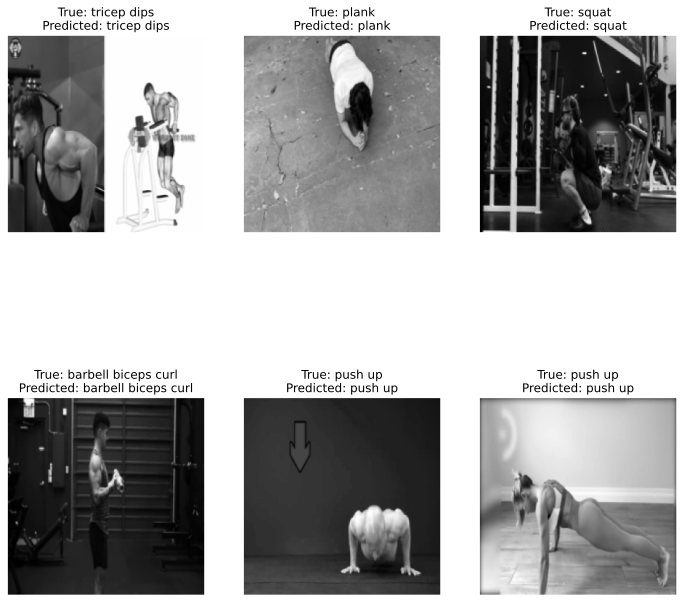

In [ ]:
def evaluate_and_display_images(net, data_iter, class_names, device=None, num_display=6):
    """Evaluate the model and display images with true and predicted values."""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device

    true_values = []
    predicted_values = []
    images = []

    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        predictions = torch.argmax(y_hat, dim=1)

        for i in range(len(predictions)):
            true_values.append(class_names[y[i]])
            predicted_values.append(class_names[predictions[i]])
            images.append(X[i].cpu())

    display_images(images[:num_display], true_values[:num_display], predicted_values[:num_display])

def display_images(images, true_values, predicted_values):
    """Display images with true and predicted values."""
    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = (num_images + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(F.to_pil_image(images[i]), cmap='gray')
            ax.set_title(f'True: {true_values[i]}\nPredicted: {predicted_values[i]}')
            ax.axis('off')

    plt.show()


evaluate_and_display_images(net, test_iter, class_names, device=d2l.try_gpu(), num_display=6)


We can therefore notice that in all six cases, the model's predictions regarding the performed exercise were correct.

# CONFUSION MATRIX

The following code is using the scikit-learn library to compute a **confusion matrix for a classification model**.

The **loop** goes through the test dataset (test_iter), moves the inputs to the specified device, computes the model's output, extracts predicted labels (y_pred), and true labels (y_true).

Then scikit-learn's **confusion_matrix function** is used to create a confusion matrix based on the true labels (y_true) and predicted labels (y_pred). The confusion matrix is a table that summarizes the performance of a classification algorithm.

In [ ]:
from sklearn.metrics import confusion_matrix

device=None
if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device

y_pred = []
y_true = []
# iterate over test data
for inputs, labels in test_iter:
        inputs = inputs.to(device)

        output=net(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth



# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

We are now going to calculate the **overall test accuracy** using the *trace* of the confusion matrix, which is the sum of its diagonal elements, which represents the true positive and the true negative counts. We are then calculating the ratio of correct predictions to the total number of instances and round the results to three decimal places:

In [ ]:
print(f'The overall test accuracy is: {round(cf_matrix.trace()/sum(sum(cf_matrix)),3)*100}%')

The overall test accuracy is: 83.8%


The overall test accuracy is 83.8% and we are now going to display the confusion matrix:

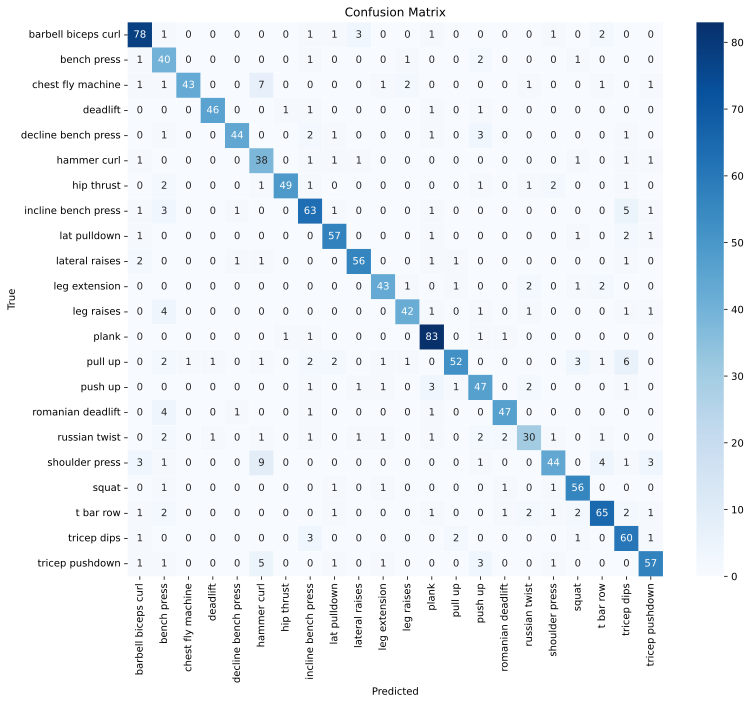

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# DISPLAY MISCLASSIFIED IMAGES


The following function helps visually inspect and understand where the model might be making **errors** by displaying a few examples of misclassified images. This code defines two functions to help evaluate and visualize the performance of a neural network classification model.

**display_images Function**:

This function takes a list of images (images), their true labels (true_values), and their predicted labels (predicted_values).
It arranges the images in a grid for display, with each row containing a specified number of images.
The function uses matplotlib to create a grid of subplots, with each subplot displaying an image along with its true and predicted labels.
The resulting grid is then displayed using plt.show().


**evaluate_and_display_misclassified Function**:

This function evaluates a given neural network (net) using a provided data iterator (data_iter).
It also takes a list of class names (class_names), a specified device (device), and the number of misclassified images to display (num_display).
It sets the neural network to evaluation mode.
The function then iterates through the data, makes predictions using the neural network, and identifies misclassified images by comparing predicted and true labels.
Misclassified images, true labels, and predicted labels are stored in separate lists (misclassified_images, true_labels, and predicted_labels).
Finally, the function calls display_images to display a subset of the misclassified images along with their true and predicted labels.

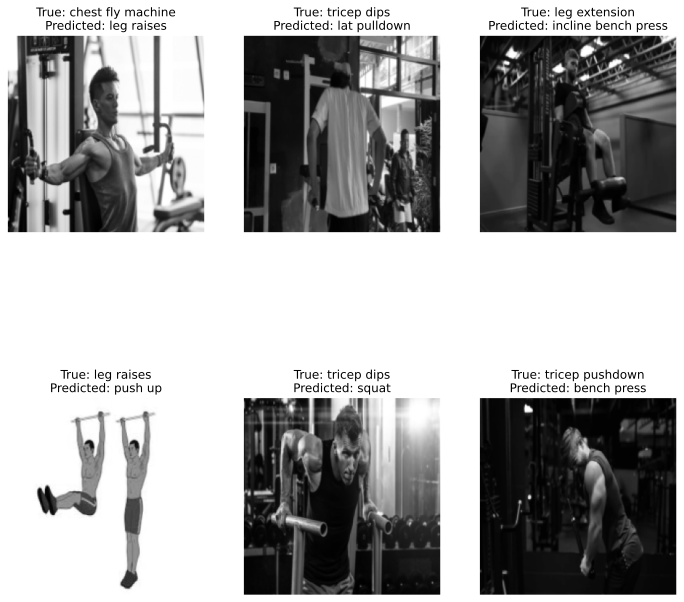

In [ ]:
def display_images(images, true_values, predicted_values):
    """Display images with true and predicted values."""
    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = (num_images + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image = images[i]
            if image.shape[0] == 1:
                image = image[0]
            ax.imshow(F.to_pil_image(image), cmap='gray')
            ax.set_title(f'True: {true_values[i]}\nPredicted: {predicted_values[i]}')
            ax.axis('off')

    plt.show()

def evaluate_and_display_misclassified(net, data_iter, class_names, device=None, num_display=10):
    """Evaluate the model and display misclassified images."""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device


    true_labels = []
    predicted_labels = []
    misclassified_images = []

    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        predictions = torch.argmax(y_hat, dim=1)

        incorrect_indices = (predictions != y).nonzero() #check for incorrectly predicted images

        for idx in incorrect_indices:
            misclassified_images.append(X[idx].cpu())
            true_labels.append(class_names[y[idx]])
            predicted_labels.append(class_names[predictions[idx]])


    display_images(misclassified_images[:num_display], true_labels[:num_display], predicted_labels[:num_display])

evaluate_and_display_misclassified(net, test_iter, class_names, device=d2l.try_gpu(), num_display=6)


We have tried to understand where the model might be making errors. For example, the model predicted "squat exercise" instead of "tricep dips" in the fifth image, but it can be noted that it was quite easy to fall into this error given the very similar position of the exercises. Also as regard the second image, we could notice that the body positions of "tricep dips" exercise and "lat pulldown" are quite similar.